# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3


***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

[updated link?](https://www.kdnuggets.com/2017/03/yhat-beginner-guide-customer-segmentation.html)

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

# Start

In [4]:
from os import environ

print(environ["OMP_NUM_THREADS"])

environ["OMP_NUM_THREADS"] = "1"

print(environ["OMP_NUM_THREADS"])

KeyError: 'OMP_NUM_THREADS'

In [14]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering, AffinityPropagation
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA


import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [5]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)

C:\Users\Nish\anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


### 1b. Explore the data

In [6]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [7]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

C:\Users\Nish\anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

 - [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) 
 - [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html)
 - columns: customer name, offer IDs
 - rows: customer, binary if they responded to offer
   - should value be > 1 if customer responded to offer more than once, n>1?
   - **NO** because it seems n is always 1 *this was set during import*
 - clean data,remove missing?

In [197]:
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


In [198]:
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


In [149]:
np.sort(df_transactions.offer_id.unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
      dtype=int64)

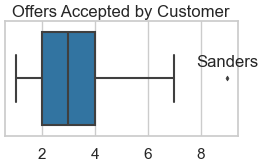

In [5]:
df = df_transactions.pivot_table(index='customer_name', columns='offer_id', values='n')
df.fillna(0, inplace=True)

plt.figure(figsize=(6,3),dpi=50)
sns.boxplot(x = df.sum(axis=1))
plt.title('Offers Accepted by Customer')
plt.text(df.sum(axis=1).max(),-0.1,
         df.sum(axis=1).sort_values(ascending=False).index[0], ha='center')
plt.show()

<font color='khaki'>**Blog Post**</font>

In [140]:
df2 = pd.merge(df_offers, df_transactions)
matrix = df2.pivot_table(index=['customer_name'], columns=['offer_id'], values=['n'])
matrix = matrix.fillna(0).reset_index()
x_cols = matrix.columns[1:]

<font color='khaki'>**Answer**</font>
- 100 customers
- 32 offers
- access array data using `df.values`, use for input `X` for model fitting

In [8]:
df = df_transactions.pivot_table(index='customer_name', columns='offer_id', values='n')
df.fillna(0, inplace=True)
df.reset_index(inplace=True)
df.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [9]:
X = df.values[:,1:]
names = df.customer_name

## 3. Modelling 
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

### Testing Cells

In [30]:
test = pd.DataFrame(index=df.customer_name, columns= ['pca_x','pca_y','cluster_5','cluster_5_pca','cluster_10'])

In [263]:
pca = PCA(2)
pca_coords = pca.fit_transform(X)
test['pca_x'] = pca_coords[:,0]
test['pca_y'] = pca_coords[:,1]

In [264]:
model = KMeans(5, n_init='auto', random_state=10)
cluster = model.fit_predict(X)
test['cluster_5'] = cluster


C:\Users\Nish\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [44]:
print('kmeans with k=5, inertia', model.inertia_)

kmeans with k=5, inertia 204.34555811571943


In [34]:
model = KMeans(10, n_init='auto', random_state=10)
cluster = model.fit_predict(X)
test['cluster_10'] = cluster

C:\Users\Nish\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [35]:
print('kmeans with k=10, inertia', model.inertia_)

kmeans with k=10, inertia 168.73846872082166


In [46]:
model = KMeans(5, n_init='auto', random_state=10)
cluster = model.fit_predict(pca_coords)
test['cluster_5_pca'] = cluster

C:\Users\Nish\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [37]:
print('kmeans with k=5 on pca transformed to 2d, inertia', model.inertia_)

kmeans with k=5 on pca transformed to 2d, inertia 10.59333062610406


In [38]:
pd.Series(cluster).value_counts().sort_index()

0    12
1    29
2    16
3    24
4    19
dtype: int64

In [272]:
pca.transform(centers)

array([[ 0.85605515,  0.00663351],
       [-0.33269723, -0.65612721],
       [-0.41435582,  1.00094011],
       [-0.34560981, -0.5800319 ],
       [-0.28438126, -0.03274596]])

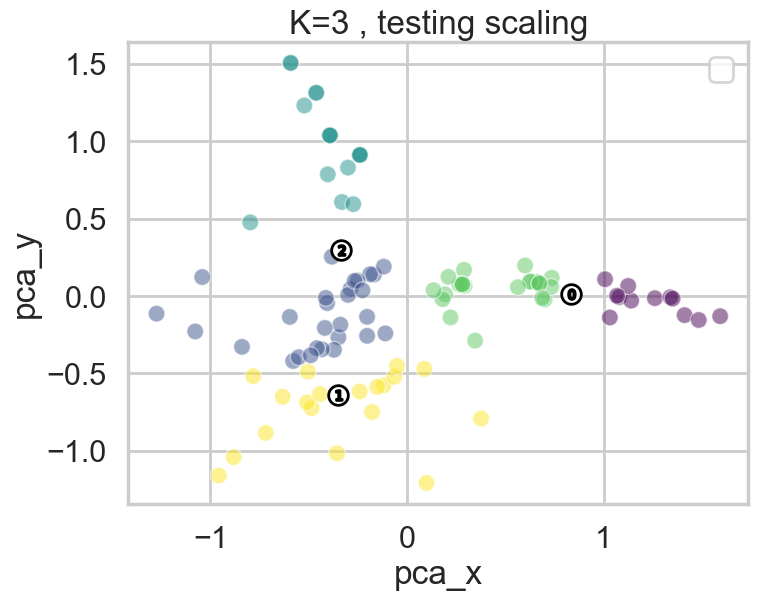

In [276]:
plt.figure(figsize=(8,6))
plt.title('K=3 , testing scaling')
sns.scatterplot(test, x='pca_x', y='pca_y', hue='cluster_5_pca', alpha=0.5,
               palette='viridis')

# Labeling the clusters
centers = pca.transform(model.cluster_centers_)
# Draw white circles at cluster centers
plt.scatter(centers[:, 0], centers[:, 1], marker='o',
c="white", alpha=1, s=200, edgecolor='k')
for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker='$%d$' % int(i), alpha=1,
    s=50, edgecolor='k')

plt.legend([])
plt.show()

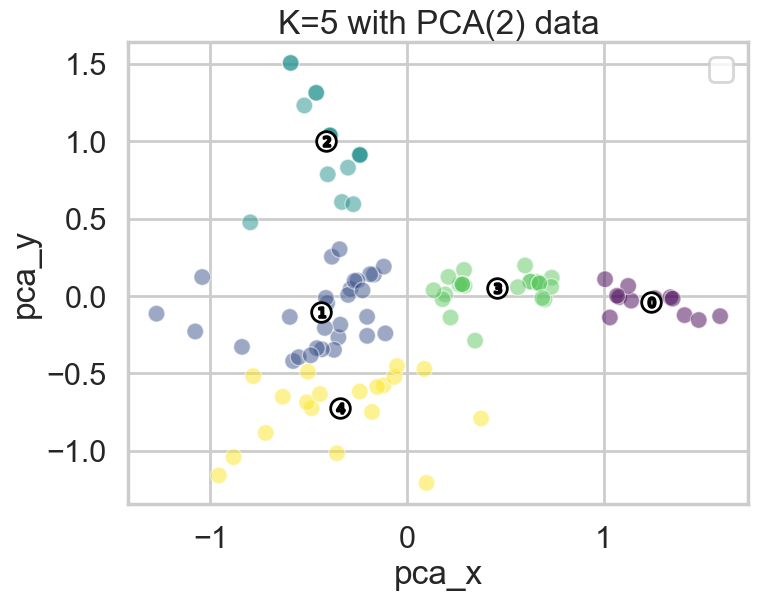

In [47]:
plt.figure(figsize=(8,6))
plt.title('K=5 with PCA(2) data')
sns.scatterplot(test, x='pca_x', y='pca_y', hue='cluster_5_pca', alpha=0.5,
               palette='viridis')

# Labeling the clusters
centers = model.cluster_centers_
# Draw white circles at cluster centers
plt.scatter(centers[:, 0], centers[:, 1], marker='o',
c="white", alpha=1, s=200, edgecolor='k')
for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker='$%d$' % int(i), alpha=1,
    s=50, edgecolor='k')

plt.legend([])
plt.show()

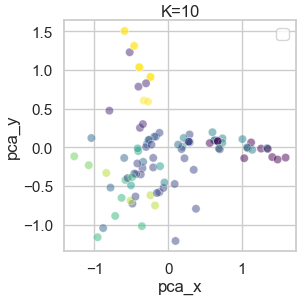

In [361]:
plt.figure(figsize=(6,6), dpi=50)
plt.title('K=10')
sns.scatterplot(test, x='pca_x', y='pca_y', hue='cluster_10', alpha=0.5,
               palette='viridis')
plt.legend([])
plt.show()

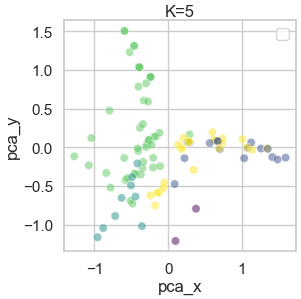

In [362]:
plt.figure(figsize=(6,6), dpi=50)
sns.scatterplot(test, x='pca_x', y='pca_y', hue='cluster_5', alpha=0.5,
               palette='viridis')
plt.title('K=5')
plt.legend([])
plt.show()

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

In [379]:
answer_2 = pd.DataFrame(columns=['inertia', 'SS'])
cluster_assignments = {}

for k in range(2,31):
    model = KMeans(k, n_init='auto', random_state=10)
    clusters = model.fit_predict(X)
    cluster_assignments[k] = clusters
    centers = model.cluster_centers_
    answer_2.loc[k,'inertia'] =  model.inertia_
    answer_2.loc[k,'SS'] = np.sum((X-centers[clusters]) ** 2)
    

C:\Users\Nish\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Nish\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Nish\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Nish\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows wi

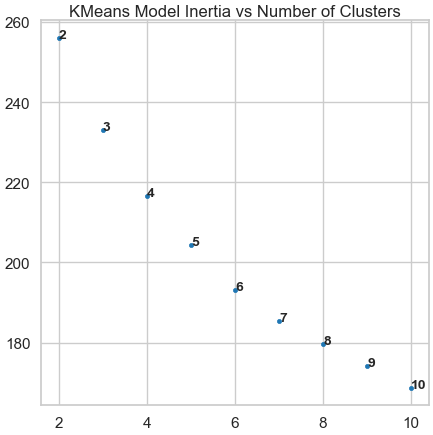

In [378]:
plt.figure(figsize=(10,10), dpi=50)
plt.plot(answer_2.index, answer_2.SS, '.')
#plt.yscale('log')
#plt.grid()
plt.title('KMeans Model Inertia vs Number of Clusters')
for val in answer_2.index:
    plt.annotate(val, (val,answer_2.loc[val,'SS']), 
                 fontsize='small', 
                 fontweight='bold')
plt.show()

In [380]:
answer_2

,inertia,SS
2,256.065934,256.065934
3,232.958583,232.958583
4,216.518613,216.518613
5,204.345558,204.345558
6,193.19565,193.19565
7,185.36369,185.36369
8,179.538695,179.538695
9,174.047619,174.047619
10,168.738469,168.738469
11,165.524673,165.524673


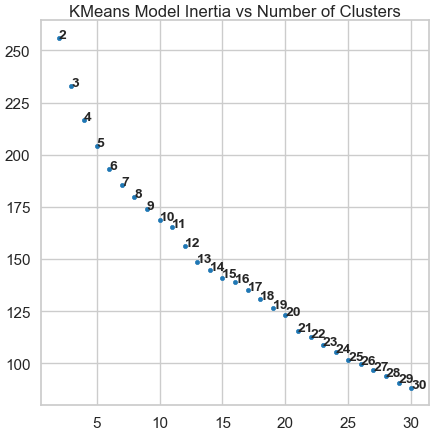

In [381]:
plt.figure(figsize=(10,10), dpi=50)
plt.plot(answer_2.index, answer_2.SS, '.')
#plt.yscale('log')
#plt.grid()
plt.title('KMeans Model Inertia vs Number of Clusters')
for val in answer_2.index:
    plt.annotate(val, (val,answer_2.loc[val,'SS']), 
                 fontsize='small', 
                 fontweight='bold')
plt.show()

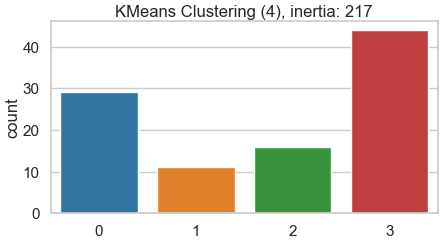

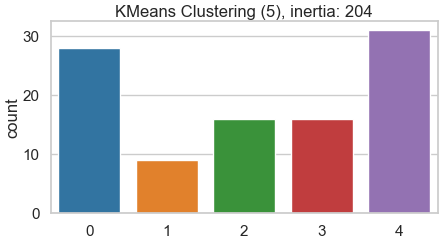

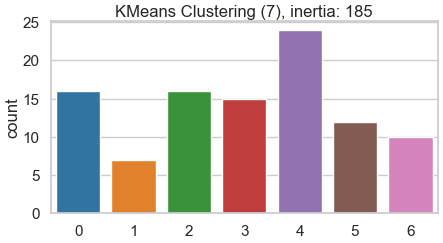

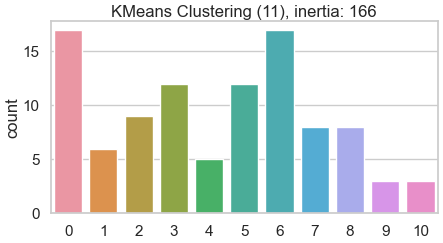

In [382]:
for k in [4,5,7,11]:
    plt.figure(figsize=(10,5), dpi=50)
    sns.countplot(x=cluster_assignments[k])
    plt.title(f'KMeans Clustering ({k}), inertia: {round(answer_2.loc[k,"inertia"])}')
    plt.show()

<font color='khaki'>**Answer**<br>
*code and plots provided above, plots may differ slightly from those used to answer questions. for example 5 looks better than 4 now.*<br>
*redoing with `random_state` specification!*<br>
> What values of  𝑆𝑆 do you believe represent better clusterings? Why?
    
    Smaller values represent better clusterings, to a limit of too many clusters. SS is an error measurement, and lower values indicate that clusters are
    more tightly defined. As the elbow method illustrates, there will be a point of diminishing returns for increasing the number of clusters, and 
    that represents the best clustering. Unfortunately, this requires visual intuition.

> Pick K . . .
    
**k=7**
    
> What challenges did you experience using the Elbow method to pick 𝐾?
 
    SS vs k, where k varies from 2 to 10 showed me two elbow regions. Choosing 4 might be the best choice if I knew there shouldn't be too many clusters, but if more
    are fairly representative of the problem, then arguments could be made for 7 or even 9 clusters.
    
    I plotted SS vs k for a greater k range (2-29). Over 20 clusters is not likely useful, as there are only 100 samples and 32 features. With the greater range 
    visualized, I think 11 could be a good choice, too.
    
    So the Elbow method is challenging given my background knowledge of the data and the sparse dataset. Arguments could be made to choose k = 4, 7, or 11. 
    The cluster count distributions for each choice is shown above. Dimenionsality reduction on the dataset should help.
</font>

---

#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

<font color='khaki'>**Answer**<br>
*code and plots below answer . . . updated with `random_state=10`*<br>  
> What  𝐾 does the plot suggest we should choose? Does it differ from what we found using the Elbow method?

**k=5**
    
    The silhouette scores, particularly when considered with inertia, k = 4,5,6 as good values. That range is somewhat agreeable with the first "elbow"
    in the plot above. However, I would have assigned a larger range of values to the elbow, maybe 5,6,7.
    
**k=3** *looked good based on the PCA clusters*
</font>

In [277]:
pca = PCA(2)
pca_coords = pca.fit_transform(X)

C:\Users\Nish\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Nish\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Nish\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Nish\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows wi

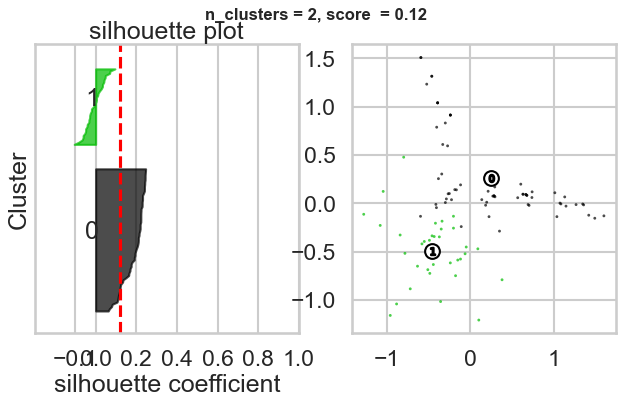

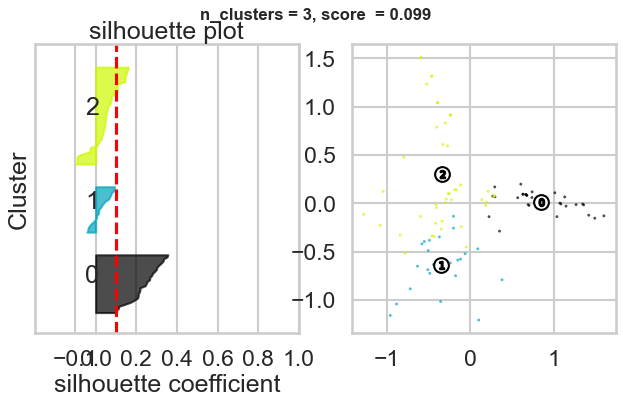

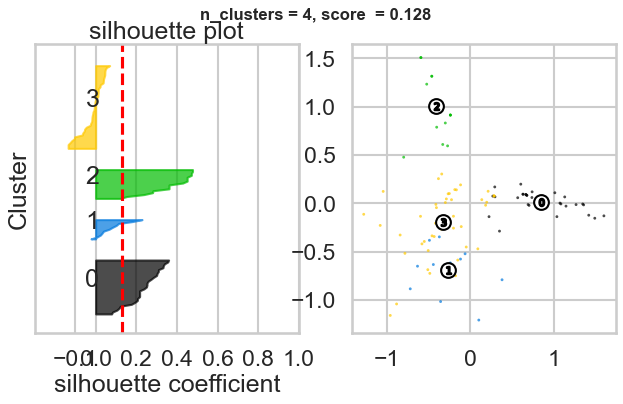

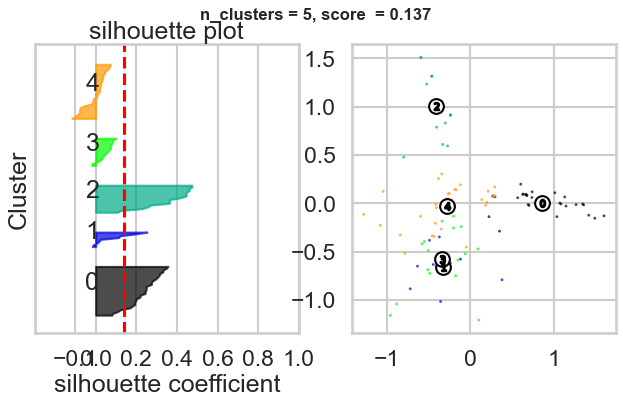

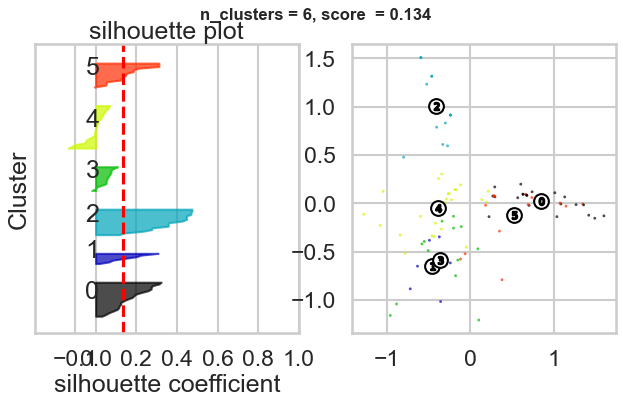

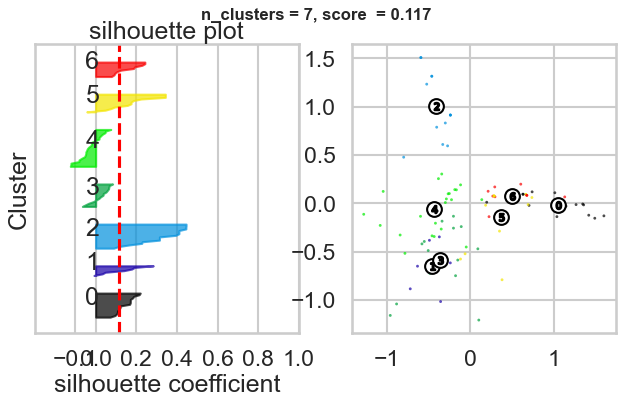

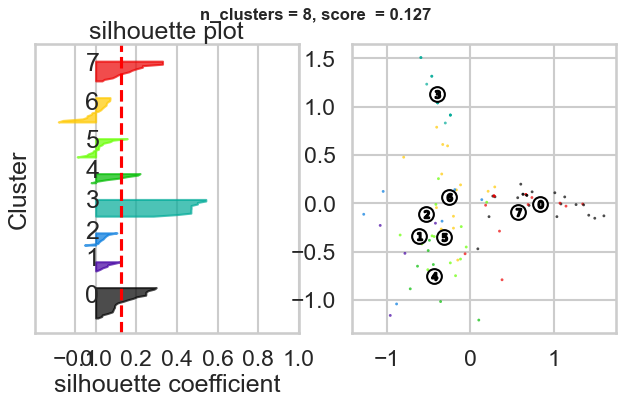

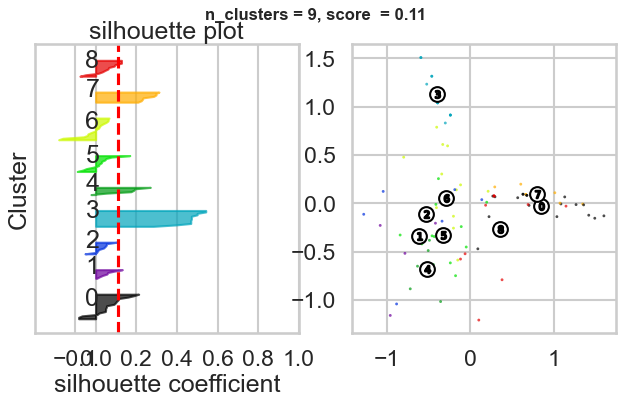

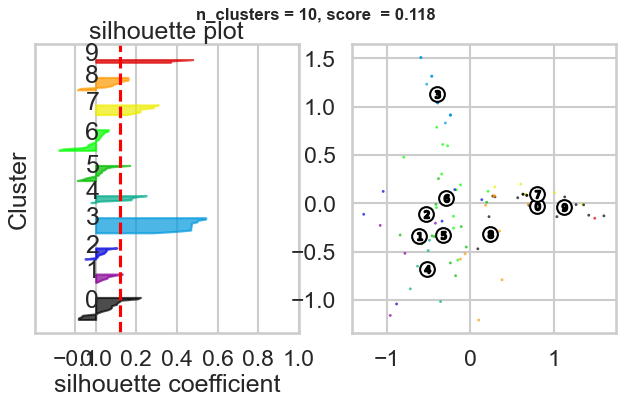

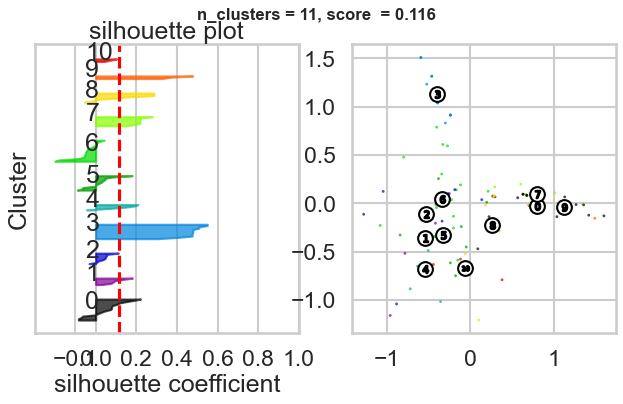

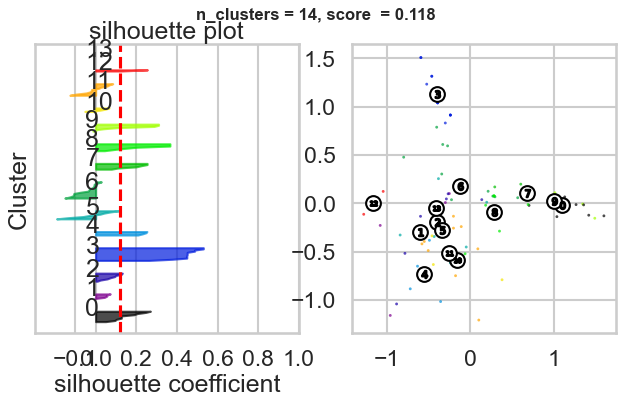

In [279]:
range_n_clusters = [2,3,4,5,6,7,8,9,10,11,14]

for n_clusters in range_n_clusters:
    
    # KMeans with specified clusters, fit to data, extract labels
    clusterer = KMeans(n_clusters, n_init='auto', random_state=10)
    clusterer.fit(X)
    cluster_labels = clusterer.labels_
    silhouette_avg = silhouette_score(X, cluster_labels)
    
    # subplot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), dpi=75,)
    ax1.set_xlim([-0.3, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    
    # silhouette scores for each samples
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("silhouette plot")
    ax1.set_xlabel("silhouette coefficient")
    ax1.set_ylabel("Cluster")    
    
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        pca_coords[:,0], pca_coords[:,1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = pca.transform(clusterer.cluster_centers_)
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    # ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("")
    ax2.set_ylabel("")
    #ax2.scatter(test.pca_x**2,test.pca_y**2,alpha=0.3)

    plt.suptitle(
        f"n_clusters = {n_clusters}, score  = {round(silhouette_avg,3)}",
        fontsize=16,
        fontweight="bold",
    )

plt.show()

**above code mostly from scikit learn [docs](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)**

In [383]:
answer_3 = pd.DataFrame(columns=['inertia', 'silhouette'])
# cluster_assignments = {}

for k in range(2,15):
    model = KMeans(k, n_init='auto', random_state=10)
    clusters = model.fit_predict(X)
    # cluster_assignments[k] = clusters
    # centers = model.cluster_centers_
    answer_3.loc[k,'inertia'] =  model.inertia_
    answer_3.loc[k,'silhouette'] =  silhouette_score(X, model.labels_)
    

C:\Users\Nish\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Nish\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Nish\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Nish\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows wi

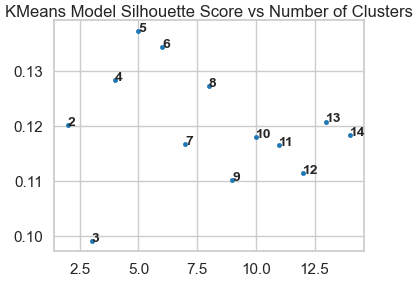

In [384]:
plt.figure(figsize=(8,6), dpi=50)
plt.plot(answer_3.index, answer_3.silhouette, '.')
#plt.yscale('log')
#plt.grid()
plt.title('KMeans Model Silhouette Score vs Number of Clusters')
for val in answer_3.index:
    plt.annotate(val, (val,answer_3.loc[val,'silhouette']), 
                 fontsize='small', 
                 fontweight='bold')
plt.show()

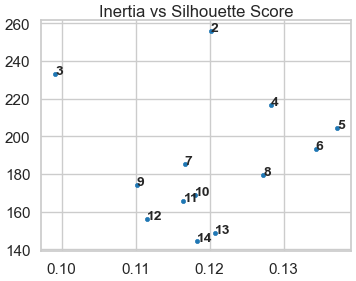

In [385]:
plt.figure(figsize=(8,6), dpi=50)
plt.title('Inertia vs Silhouette Score')
plt.plot(answer_3.silhouette, answer_3.inertia, '.')
for val in answer_3.index:
    plt.annotate(val, (answer_3.loc[val,'silhouette'], answer_3.loc[val,'inertia']), 
                 fontsize='small', 
                 fontweight='bold')
plt.show()

#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Gap Statistic Notes - make function later? adapt [code](https://github.com/milesgranger/gap_statistic/tree/master)


*old gap statistic package [here](https://github.com/milesgranger/gap_statistic), [optimalK.py](https://github.com/milesgranger/gap_statistic/blob/master/gap_statistic/optimalK.py)*

```python
from gap_statistic import OptimalK

n_clusters = optimalK(X, cluster_array=np.arange(1, 15))
print('Optimal clusters: ', n_clusters)

# DataFrame with gap statistics:
optimalK.gap_df.head()

# plot from DF marking optimal K
plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=3)
plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters,
            optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].gap_value, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()
```

**Calculate Dispersion**
```python
def _calculate_dispersion(
    X: Union[pd.DataFrame, np.ndarray], labels: np.ndarray, centroids: np.ndarray
) -> float:
    """
    Calculate the dispersion between actual points and their assigned centroids
    """
    disp = np.sum(
        np.sum(
            [np.abs(inst - centroids[label]) ** 2 for inst, label in zip(X, labels)]
        )
    )
    return disp
```

**Calculate Gap Statistic**
```python
def _calculate_gap(
    self, X: Union[pd.DataFrame, np.ndarray], n_refs: int, n_clusters: int
) -> GapCalcResult:
    """
    Calculate the gap value of the given data, n_refs, and number of clusters.
    Return the resulting gap value and n_clusters
    """
    # Holder for reference dispersion results
    ref_dispersions = np.zeros(n_refs)

    # Compute the range of each feature
    X = np.asarray(X)
    a, b = X.min(axis=0, keepdims=True), X.max(axis=0, keepdims=True)

    # For n_references, generate random sample and perform kmeans getting resulting dispersion of each loop
    for i in range(n_refs):
        # Create new random reference set uniformly over the range of each feature
        random_data = self._rs.random_sample(size=X.shape) * (b - a) + a

        # Fit to it, getting the centroids and labels, and add to accumulated reference dispersions array.
        centroids, labels = self.clusterer(
            random_data, n_clusters, **self.clusterer_kwargs
        )  # type: Tuple[np.ndarray, np.ndarray]
        dispersion = self._calculate_dispersion(
            X=random_data, labels=labels, centroids=centroids
        )
        ref_dispersions[i] = dispersion

    # Fit cluster to original data and create dispersion calc.
    centroids, labels = self.clusterer(
        X, n_clusters, **self.clusterer_kwargs
    )  # type: Tuple[np.ndarray, np.ndarray]
    dispersion = self._calculate_dispersion(X=X, labels=labels, centroids=centroids)

    # Calculate gap statistic
    ref_log_dispersion = np.mean(np.log(ref_dispersions))
    log_dispersion = np.log(dispersion)
    gap_value = ref_log_dispersion - log_dispersion
    # compute standard deviation
    sdk = np.sqrt(np.mean((np.log(ref_dispersions) - ref_log_dispersion) ** 2.0))
    sk = np.sqrt(1.0 + 1.0 / n_refs) * sdk

    # Calculate Gap* statistic
    # by "A comparison of Gap statistic definitions with and
    # with-out logarithm function"
    # https://core.ac.uk/download/pdf/12172514.pdf
    gap_star = np.mean(ref_dispersions) - dispersion
    sdk_star = np.sqrt(np.mean((ref_dispersions - dispersion) ** 2.0))
    sk_star = np.sqrt(1.0 + 1.0 / n_refs) * sdk_star

    return GapCalcResult(
        gap_value,
        int(n_clusters),
        ref_dispersions.std(),
        sdk,
        sk,
        gap_star,
        sk_star,
    )
```

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

<font color='khaki'>**Answer 4**<br>
*tried 5 clusters with `random_state=10`, tried again after examining plot and determined **3 clusters** is best*<br>  
> How do the clusters look? Based on what you see, what seems to be the best value for  𝐾? Moreover, which method of choosing  𝐾 seems to have produced the optimal result visually?

The clusters look ok, 5 clusters looks like too many. I want to try again with k=3 and k=4. 
For this dataset, plotting the PCA 2d decomposition may be the best way to start choosing values of K. 
It was not clear when to cutoff the interpretation for *better* results from the **elbow method** with **inertia** or **silhouette score**.
    
After trying k=3 and k=4, it looks like **k=3** is the best clustering of the customer data.

</font>

In [281]:
pca = PCA(2)
pca_coords = pca.fit_transform(StandardScaler().fit_transform(X))

centers = {}

answer_4 = pd.DataFrame(columns = ['customer', 'x', 'y'])
answer_4['x'] = pca_coords[:,0]
answer_4['y'] = pca_coords[:,1]
answer_4['customer'] = df.customer_name

for k in [3,4,5,6]:
    model = KMeans(k, n_init='auto', random_state=10)
    answer_4[f'cluster{k}_id'] =  model.fit_predict(X)
    centers[k] = model.cluster_centers_

C:\Users\Nish\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Nish\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Nish\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Nish\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows wi

In [282]:
answer_4.head()

,customer,x,y,cluster3_id,cluster4_id,cluster5_id,cluster6_id
0,Adams,-2.487987,-0.250051,0,0,0,0
1,Allen,0.734965,-0.132604,2,3,4,4
2,Anderson,0.058854,2.914504,2,2,2,2
3,Bailey,-1.650273,-0.289562,0,0,0,0
4,Baker,-0.398132,-1.991045,1,3,3,3


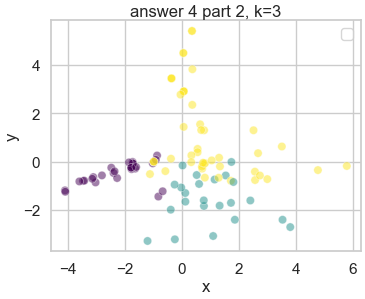

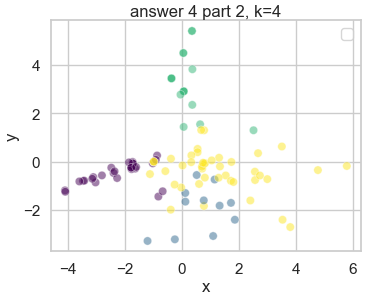

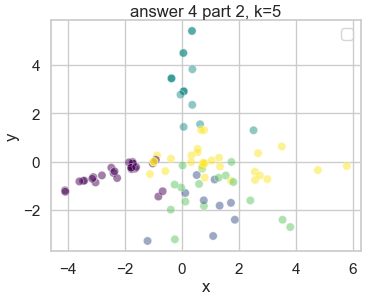

In [283]:
for k in [3,4,5]:
    plt.figure(figsize=(8,6), dpi=50)
    sns.scatterplot(answer_4, x='x', y='y', hue=f'cluster{k}_id', palette='viridis', alpha=0.5)
    plt.legend([])
    plt.title(f'answer 4 part 2, k={k}')
    plt.show()

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

<font color='khaki'>**Answer 4**<br>  
> . . . optimal number of dimensions. What is it?

It is after **3 components**.

In [88]:
pca = PCA() # default is None, all components will be kept
pca.fit(X)

PCA()

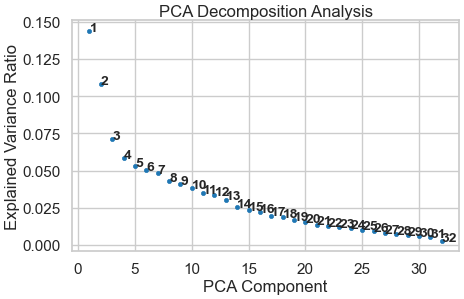

In [89]:
plt.figure(figsize=(10,6), dpi=50)
comps = [val+1 for val in range(pca.explained_variance_ratio_.shape[0])]
plt.plot(comps, 
         pca.explained_variance_ratio_, '.')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('PCA Component')
plt.title('PCA Decomposition Analysis')
for x,y in zip(comps, pca.explained_variance_ratio_):
    plt.annotate(x, (x,y), 
                 fontsize='small', 
                 fontweight='bold')

## 4. Conclusions and next steps
### 4a. Conclusions
What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call. 

<font color='khaki'>**Answer 4**

Based on the analysis, I would segment the customers into 3 groups and see if there are obvious relationships in the response clusters.
    
I would want to try this analysis again using more of the source data, or perhaps simply adding a magnitude to the vectorized data (let n be greater than 1).
The projection resulting from PCA decomposition did not show well-defined clusters.

</font>

### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


<font color='khaki'>**Answer 4**<br>  
> How do their results compare? Which performs the best? Tell a story why you think it performs the best.

Model defaults do not give fair comparisons (plots at bottom). For Spectral and Agglomerative clustering, I set the number of clusters to 3 to evaluate against the PCA grid. 

 - **DBSCAN** failed to cluster the data, returning `-1` for labels. It might require a grid search to find a suitable epsilon.
    - GridSearchCV performed at bottom, unable to find parameters with 0 noisy labels and more than one cluster    
    - similar story with **HDBSCAN**
 - **AffinityPropagation** would require some tuning as well. It clusters the data into 14 groups, which is too many, but the color palette indicates decent relationships.
    
**Spectral**, **Agglomerative**, and **KMeans** are similar with 3 clusters specified. The first two are more similar to each other than KMeans. 
    
I like the clusters provided by the **AgglomerativeClustering** algorithm the most, at a glance.

In [471]:
pca = PCA(2)
pca_coords = pca.fit_transform(X)
answer_6 = pd.DataFrame()
answer_6['x'] = pca_coords[:,0]
answer_6['y'] = pca_coords[:,1]

In [477]:
models = {
    'AffinityPropagation':AffinityPropagation(random_state=10),
    'SpectralClustering (3)':SpectralClustering(3,random_state=10), # set clusters?
    'AgglomerativeClustering (3)':AgglomerativeClustering(3), # set clusters?
    'KMeans (3)':KMeans(3, n_init='auto', random_state=10),
    'DBSCAN':DBSCAN()
}

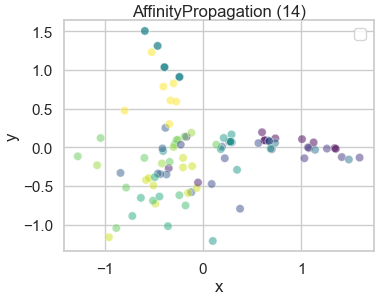

C:\Users\Nish\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


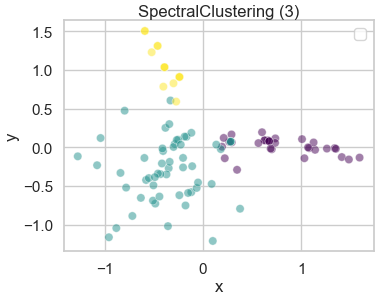

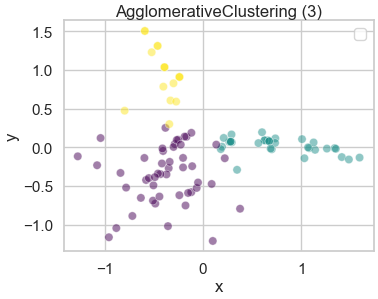

C:\Users\Nish\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


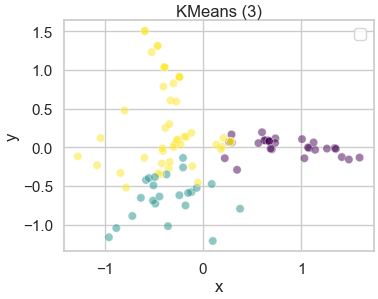

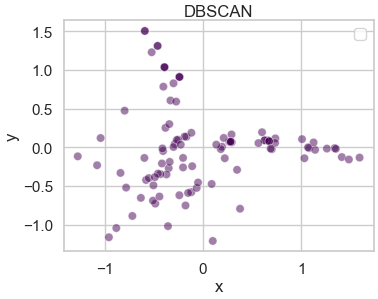

In [478]:
for model_name, model in models.items():
    clusters = model.fit_predict(X)
    answer_6[model_name] = clusters
    plt.figure(figsize=(8,6), dpi=50)
    sns.scatterplot(answer_6, x='x', y='y', hue=model_name, palette='viridis', alpha=0.5)
    
    plt.legend([])
    title = model_name
    if model_name == 'AffinityPropagation':
        title = f"{title} ({model.cluster_centers_indices_.shape[0]})"

    plt.title(title)
    plt.show()

*Model defaults, only random state=10 set where applicable*

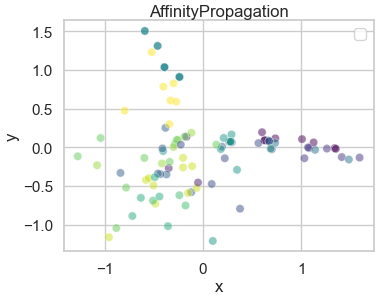

C:\Users\Nish\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


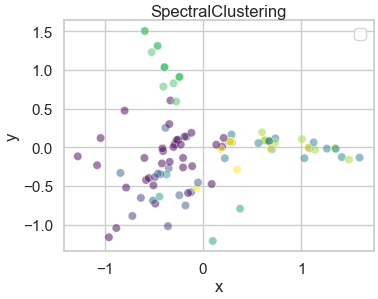

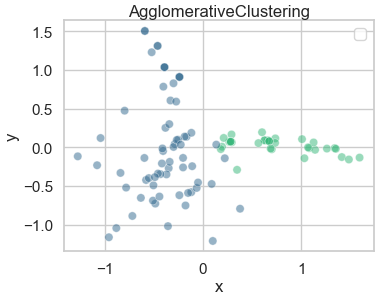

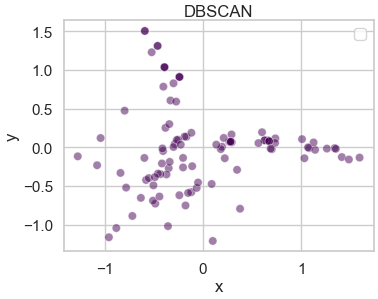

In [445]:
for model_name, model in models.items():
    clusters = model.fit_predict(X)
    answer_6[model_name] = clusters
    plt.figure(figsize=(8,6), dpi=50)
    sns.scatterplot(answer_6, x='x', y='y', hue=model_name, palette='viridis', alpha=0.5)
    
    plt.legend([])
    title = model_name
    if model_name == 'AffinityPropagation':
        title = f"{title} ({model.cluster_centers_indices_.shape[0]})"
    else:
        plt.title(title)
    plt.show()

#### DBSCAN Grid Search

 - try with transformed data

*HDBSCAN tried, too*

In [15]:
from sklearn.model_selection import GridSearchCV

**[User Guide 2.3.7 notes](https://scikit-learn.org/stable/modules/clustering.html#dbscan)** | [demo](https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py)
 - 2 parameters: `min_samples` and `eps`
   - higher `min_samples`, lower `eps` indicate higher density needed to form a cluster
 - `min_samples` controls how tolerant model is towards noise, increase for noisy/large datasets
 - `eps` is crucial to choose appropriately, ***usually cannot be left at default***
   - controls local neighborhood of points
   - too small and clustering will fail (what's happening now), resulting in `-1` labels
   - too large and clusters will merge together, to the point of a signle cluster
 - references for choosing eps (based on elblow plot?)
   - https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf
   - https://doi.org/10.1145/3068335
 - try HDBSCAN
   - clusters not assumed to have homogenous densities
   - see guide for background info, only need to tune min_samples
 

**Custom Scoring Function** [docs](https://scikit-learn.org/stable/modules/model_evaluation.html#implementing-your-own-scoring-object)

 - take in estimator object, X data, y=None (unsupervised)
 - sum noisy labels (-1), divide by # of clusters 
   - for now good metric as DBSCAN either clusters all together or classifies as noise
     - `scoring=lambda est,x: (est.labels_==-1).sum()/np.unique(model.labels_[model.labels_>-1]).shape[0]`
   - sum of -1 labels could be fine, too. No parameters yield 0!
 - settled on two methods: noise (noisy label percentage) and clusters (# clusters)

In [186]:
np.linspace(1,2,20)

array([1.        , 1.05263158, 1.10526316, 1.15789474, 1.21052632,
       1.26315789, 1.31578947, 1.36842105, 1.42105263, 1.47368421,
       1.52631579, 1.57894737, 1.63157895, 1.68421053, 1.73684211,
       1.78947368, 1.84210526, 1.89473684, 1.94736842, 2.        ])

In [213]:
parameters = {
    'eps':np.linspace(1,3,30),
    'min_samples':[3,4,5],
}

In [230]:
clf = GridSearchCV(DBSCAN(), param_grid = parameters, scoring=\
                   {
        'noise': lambda est,x: (est.labels_==-1).sum()/est.labels_.shape[0],
        'clusters': lambda est,x: np.unique(est.labels_[est.labels_>=0]).shape[0],
                   }, refit=False)

In [231]:
clf.fit(X)

GridSearchCV(estimator=DBSCAN(),
             param_grid={'eps': array([1.        , 1.06896552, 1.13793103, 1.20689655, 1.27586207,
       1.34482759, 1.4137931 , 1.48275862, 1.55172414, 1.62068966,
       1.68965517, 1.75862069, 1.82758621, 1.89655172, 1.96551724,
       2.03448276, 2.10344828, 2.17241379, 2.24137931, 2.31034483,
       2.37931034, 2.44827586, 2.51724138, 2.5862069 , 2.65517241,
       2.72413793, 2.79310345, 2.86206897, 2.93103448, 3.        ]),
                         'min_samples': [3, 4, 5]},
             refit=False,
             scoring={'clusters': <function <lambda> at 0x000001B762AF7130>,
                      'noise': <function <lambda> at 0x000001B762B56200>})

In [235]:
results = pd.DataFrame(clf.cv_results_)[['param_eps','param_min_samples','mean_test_noise','mean_test_clusters']]

In [240]:
results[results.mean_test_noise>0].sort_values(['mean_test_noise','mean_test_clusters'], ascending=[True,False])

,param_eps,param_min_samples,mean_test_noise,mean_test_clusters
56,2.241379,5,0.0025,1.0
59,2.310345,5,0.0025,1.0
62,2.37931,5,0.0025,1.0
65,2.448276,5,0.0025,1.0
45,2.034483,3,0.0325,1.0
46,2.034483,4,0.0325,1.0
48,2.103448,3,0.0325,1.0
49,2.103448,4,0.0325,1.0
51,2.172414,3,0.0325,1.0
52,2.172414,4,0.0325,1.0


In [238]:
results[results.mean_test_noise==0]

,param_eps,param_min_samples,mean_test_noise,mean_test_clusters
54,2.241379,3,0.0,1.0
55,2.241379,4,0.0,1.0
57,2.310345,3,0.0,1.0
58,2.310345,4,0.0,1.0
60,2.37931,3,0.0,1.0
61,2.37931,4,0.0,1.0
63,2.448276,3,0.0,1.0
64,2.448276,4,0.0,1.0
66,2.517241,3,0.0,1.0
67,2.517241,4,0.0,1.0


In [1]:
# need scikit-learn 1.3
from sklearn.cluster import HDBSCAN
model = HDBSCAN()

In [10]:
model.fit(X)

HDBSCAN()

In [11]:
model.labels_

array([ 0, -1,  1, -1, -1, -1,  1,  0, -1,  0, -1,  1, -1, -1, -1,  1, -1,
        1, -1, -1,  0, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1,  1,  1,  0, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1,  1, -1,  0,  1, -1, -1, -1, -1,  0, -1, -1, -1, -1,  1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1,  0,
       -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1],
      dtype=int64)

In [12]:
parameters = {
#    'eps':np.linspace(1,3,30),
    'min_cluster_size':[3,4,5],
}

In [16]:
clf = GridSearchCV(HDBSCAN(), param_grid = parameters, scoring=\
                   {
        'noise': lambda est,x: (est.labels_==-1).sum()/est.labels_.shape[0],
        'clusters': lambda est,x: np.unique(est.labels_[est.labels_>=0]).shape[0],
                   }, refit=False)

In [17]:
clf.fit(X)

GridSearchCV(estimator=HDBSCAN(), param_grid={'min_cluster_size': [3, 4, 5]},
             refit=False,
             scoring={'clusters': <function <lambda> at 0x000002CA850BF0A0>,
                      'noise': <function <lambda> at 0x000002CA84F96DD0>})

In [23]:
pd.DataFrame(clf.cv_results_)[['param_min_cluster_size','mean_test_noise','mean_test_clusters']]

,param_min_cluster_size,mean_test_noise,mean_test_clusters
0,3,0.605,4.8
1,4,0.645,2.2
2,5,0.565,2.4


In [25]:
pd.DataFrame(clf.cv_results_).sort_values(['mean_test_noise','mean_test_clusters'], ascending=[True,False])\
    [['param_min_cluster_size','mean_test_noise','mean_test_clusters']]

,param_min_cluster_size,mean_test_noise,mean_test_clusters
2,5,0.565,2.4
0,3,0.605,4.8
1,4,0.645,2.2
